In [2]:
import datetime as dt
import os
import subprocess
import time
import tkinter as tk
import re
import pandas as pd
import psutil
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome, ChromeOptions
import datetime
import chromedriver_autoinstaller
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
chromedriver_autoinstaller.install()  # check if chromedriver has updated version, if yes, update it

## settings start here
today_date = datetime.datetime.now().date().strftime("%Y%m%d")
today_date = '220504'
# today_date = today_date[2:]
chrome_path = 'C:/Program Files (x86)/Google/Chrome/Application/chrome.exe'


In [4]:
subprocess.Popen(chrome_path + ' --remote-debugging-port=9222')  # open a subprocess
options = ChromeOptions()  # options
# options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")  # debugger options, avoid being banned from website
browser = Chrome(options=options)
browser.get(f'https://www.hkex.com.hk/eng/stat/dmstat/dayrpt/hsio{today_date}.htm')

# read html
html = browser.execute_script("return document.documentElement.outerHTML")
soup = BeautifulSoup(html, features='lxml')

# # all data read, close processes.
# chrome_name = 'chrome.exe'
# chrome_driver_name = 'chromedriver.exe'
# for proc in psutil.process_iter():
#     if proc.name() == chrome_name or proc.name() == chrome_driver_name:
#         p = psutil.Process(proc.pid)
#         p.kill()

# data
pre_context = str(soup.findAll('pre')[0])

In [5]:
def get_paragraph_from_pre(pre_context):
    # lots of paragraphs in the page, different paragraphs have same columns, they should be combined together
    a_tags = re.findall('<a name="month\d+"></a>', pre_context, re.S)
    paragraph_li = []
    # get every paragraph
    for i in range(0, len(a_tags) - 1):
        paragraph_li.append(pre_context.split(str(a_tags[i]))[1].split(str(a_tags[i + 1]))[0])
    paragraph_li.append(pre_context.split(str(a_tags[-1]))[1].split('</pre>')[0])
    return (paragraph_li)


def get_str_table_form_paragraph(text):
    # combine the paragraphs
    tem_table_li = []
    for item in text.split('\n\n'):
        if len(item) >= 5000:
            tem_table_li.append(item)

    return tem_table_li


def build_datalist_from_str_table(text):
    # convert texts to lists
    p1 = []
    p2 = []
    p3 = []

    lines = text.split('\n')
    lines = [line for line in lines if len(line) > 5]

    for line in lines:
        p1.append(line.split('|')[0])
        p2.append(line.split('|')[1])
        p3.append(line.split('|')[2])
    return p1, p2, p3


def build_dataframe_from_datalist(p):
    # build the dataframe from lists.
    t1 = ['CONTRACT STRIKE *OPENING  *DAILY  *DAILY   CLOSE  VOLUME  ',
          'MONTH     PRICE    PRICE    HIGH     LOW   PRICE          ']
    t2 = ['*OPENING  *DAILY  *DAILY  O.Q.P.   O.Q.P.  IV%     VOLUME  ',
          '   PRICE    HIGH     LOW   CLOSE   CHANGE                  ']
    t3 = [' *Contract *Contract     Volume      Open Change in', '      High       Low             Interest        OI']
    title_lines = p[:2]
    tabletype = ""
    if title_lines == t1:
        tabletype = 't1'
    elif title_lines == t2:
        tabletype = 't2'
    elif title_lines == t3:
        tabletype = 't3'
    else:
        pass
    content_lines = p[2:]
    new_lines = []
    for line in content_lines:
        new_lines.append([item for item in line.split('  ') if (item) != ''])
    df = pd.DataFrame(new_lines)
    return ({tabletype: df})


paragraphs = get_paragraph_from_pre(pre_context)

paragraph = paragraphs[0]

str_table = get_str_table_form_paragraph(paragraph)[0]

datalist = build_datalist_from_str_table(str_table)[0]

build_dataframe_from_datalist(datalist)

{'t1':           0        1  2   3   4   5   6
 0    MAY-22  13000 C  0   0   0   0   0
 1    MAY-22  13100 C  0   0   0   0   0
 2    MAY-22  13200 C  0   0   0   0   0
 3    MAY-22  13300 C  0   0   0   0   0
 4    MAY-22  13400 C  0   0   0   0   0
 ..      ...      ... ..  ..  ..  ..  ..
 116  MAY-22  29200 C  0   0   0   0   0
 117  MAY-22  29400 C  0   0   0   0   0
 118  MAY-22  29600 C  0   0   0   0   0
 119  MAY-22  29800 C  0   0   0   0   0
 120  MAY-22  30000 C  0   0   0   0   0
 
 [121 rows x 7 columns]}

In [6]:
# build lists to dataframes
dic_li = []
paragraphs = get_paragraph_from_pre(pre_context)
for paragraph in paragraphs:
    str_tables = get_str_table_form_paragraph(paragraph)
    for str_table in str_tables:
        datalists = build_datalist_from_str_table(str_table)
        for datalist in datalists:
            dic_li.append(build_dataframe_from_datalist(datalist))

t1_li = []
t2_li = []
t3_li = []

In [7]:
for i in range(len(dic_li)):
    if list(dic_li[i].keys())[0] == 't1':
        t1_li.append(dic_li[i]['t1'])
    elif list(dic_li[i].keys())[0] == 't2':
        t2_li.append(dic_li[i]['t2'])
    if list(dic_li[i].keys())[0] == 't3':
        t3_li.append(dic_li[i]['t3'])

df_t1 = pd.concat(t1_li).reset_index(drop=True)
df_t2 = pd.concat(t2_li).reset_index(drop=True)
df_t3 = pd.concat(t3_li).reset_index(drop=True)

In [8]:
# organize data
strikes = df_t1.iloc[:, 1:2]
expire_dates = df_t1.iloc[:, 0:1]

df_t2.insert(0, 'b', strikes)

df_t2.insert(0, 'a', expire_dates)

df_t3.insert(0, 'b', strikes)

df_t3.insert(0, 'a', expire_dates)

In [9]:
df_t1.columns = ['month_contract', 'strikecp', 'open', 'high', 'low', 'close', 'volume']
df_t2.columns = ['month_contract', 'strikecp', 'open', 'high', 'low', 'O.Q.P. Close', 'O.Q.P. Change', 'IV%', 'volume']
df_t3.columns = ['month_contract', 'strikecp', 'contract_high', 'contract_low', 'volume', 'open_interest',
                 'change_in_OI']

In [10]:
# split strike and call/put, they are different attributes, splitting is better
# strike to int, and call/put to string
df_t1['strike'] = df_t1['strikecp'].apply(lambda x: x[:-2]).astype(int)
df_t1['call/put'] = df_t1['strikecp'].apply(lambda x: x[-1:])
df_t2['strike'] = df_t2['strikecp'].apply(lambda x: x[:-2]).astype(int)
df_t2['call/put'] = df_t2['strikecp'].apply(lambda x: x[-1:])
df_t3['strike'] = df_t3['strikecp'].apply(lambda x: x[:-2]).astype(int)
df_t3['call/put'] = df_t3['strikecp'].apply(lambda x: x[-1:])

In [11]:
df_t1 = df_t1[['month_contract', 'strike', 'call/put', 'open', 'high', 'low', 'close', 'volume']]
df_t2 = df_t2[
    ['month_contract', 'strike', 'call/put', 'open', 'high', 'low', 'O.Q.P. Close', 'O.Q.P. Change', 'IV%', 'volume']]
df_t3 = df_t3[['month_contract', 'strike', 'call/put', 'contract_high', 'contract_low', 'volume', 'open_interest',
               'change_in_OI']]

In [37]:
# convert all numerical values into float
df_t1['open'] = df_t1['open'].astype(float)
df_t1['high'] = df_t1['high'].astype(float)
df_t1['low'] = df_t1['low'].astype(float)
df_t1['close'] = df_t1['close'].astype(float)
df_t1['volume'] = df_t1['volume'].astype(float)

In [38]:
# convert all numerical values into float
df_t2['open'] = df_t2['open'].astype(float)
df_t2['high'] = df_t2['high'].astype(float)
df_t2['low'] = df_t2['low'].astype(float)
df_t2['O.Q.P. Close'] = df_t2['O.Q.P. Close'].astype(float)
df_t2['O.Q.P. Change'] = df_t2['O.Q.P. Change'].astype(float)
df_t2['IV%'] = df_t2['IV%'].astype(float)
df_t2['volume'] = df_t2['volume'].astype(float)

In [39]:
# convert all numerical values into float
df_t3['contract_high'] = df_t3['contract_high'].astype(float)
df_t3['contract_low'] = df_t3['contract_low'].astype(float)
df_t3['volume'] = df_t3['volume'].astype(float)
df_t3['open_interest'] = df_t3['open_interest'].astype(float)
df_t3['change_in_OI'] = df_t3['change_in_OI'].astype(float)

month_contract
AUG-22      9
DEC-22     17
JUL-22     26
JUN-22     53
MAY-22    101
SEP-22     11
Name: no., dtype: int64


C:\Users\JEFFER~1\AppData\Local\Temp/ipykernel_15720/2104885242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_non_zero['no.'] = range(len(df_t2_non_zero))  # insert an auto-increment column


Text(0.5, 1.0, 'Month Contract Percentage')

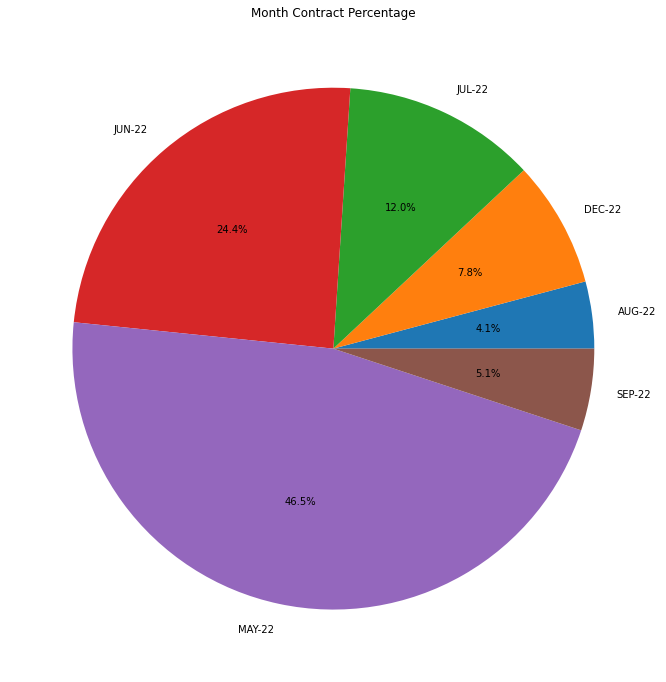

In [72]:
df_t2_non_zero = df_t2[df_t2['open'] != 0]  # filter options with trades only
df_t2_non_zero['no.'] = range(len(df_t2_non_zero))  # insert an auto-increment colum
n
st_stat1 = df_t2_non_zero.groupby(['month_contract']).count()  # group by month_contract and count numbers of different months contracts
st_stat1 = st_stat1[:]['no.']
print(st_stat1)

fig, ax1 = plt.subplots(1, figsize=(15, 12))
ax1.pie(st_stat1, labels=st_stat1.index, autopct='%1.1f%%')  # plot a pie chart
ax1.set_title('Month Contract Percentage')  # set the chart title


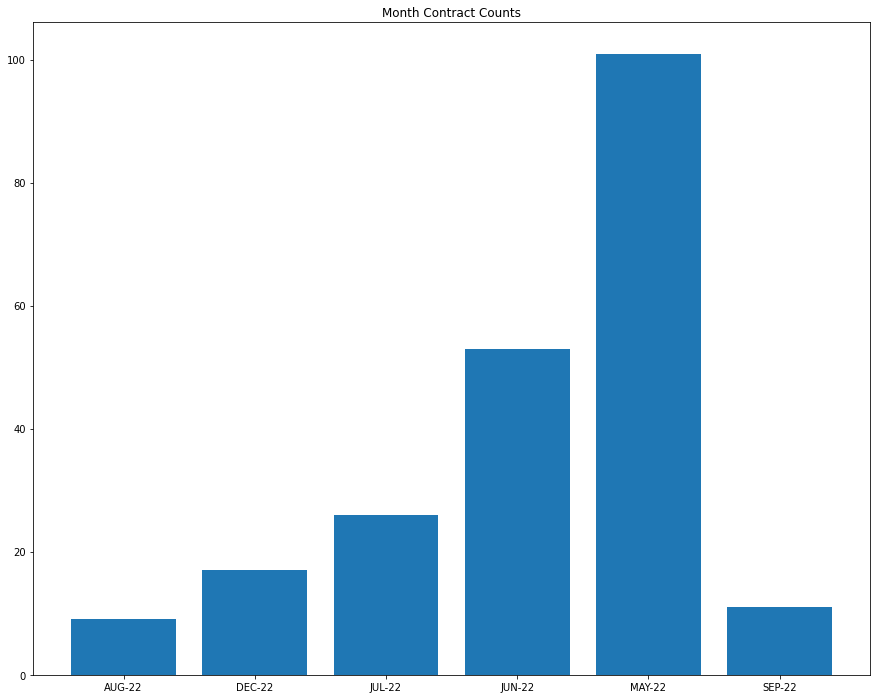

In [41]:
# st_stat1 = df_t2.groupby(['month_contract']).count()
fig, ax1 = plt.subplots(1, figsize=(15, 12))
ax1.bar(st_stat1.index, st_stat1)  # plot a bar chart
ax1.set_title('Month Contract Counts')  # set the chart title
plt.show()

In [73]:
df_t2_non_zero = df_t2[df_t2['open'] != 0]  # filter options with trades only
df_t2_non_zero['no.'] = range(len(df_t2_non_zero))  # insert an auto-increment column
st_stat1 = df_t2_non_zero.groupby(['call/put']).count()  # group by month_contract and count numbers of different months contracts
st_stat1 = st_stat1[:]['no.']
print(st_stat1)

fig, ax1 = plt.subplots(1, figsize=(15, 12))
ax1.pie(st_stat1, labels=st_stat1.index, autopct='%1.1f%%')  # plot a chart
ax1.set_title('Call/Put Percentage')  # set the chart title

C:\Users\JEFFER~1\AppData\Local\Temp/ipykernel_15720/602448188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_non_zero['no.'] = range(len(df_t2_non_zero))  # insert an auto-increment column


,month_contract,strike,open,high,low,O.Q.P. Close,O.Q.P. Change,IV%,volume,no.
call/put,,,,,,,,,,
C,100,100,100,100,100,100,100,100,100,100
P,117,117,117,117,117,117,117,117,117,117


Text(0.5, 1.0, 'MAY-22, Call option, Volatility Smile')

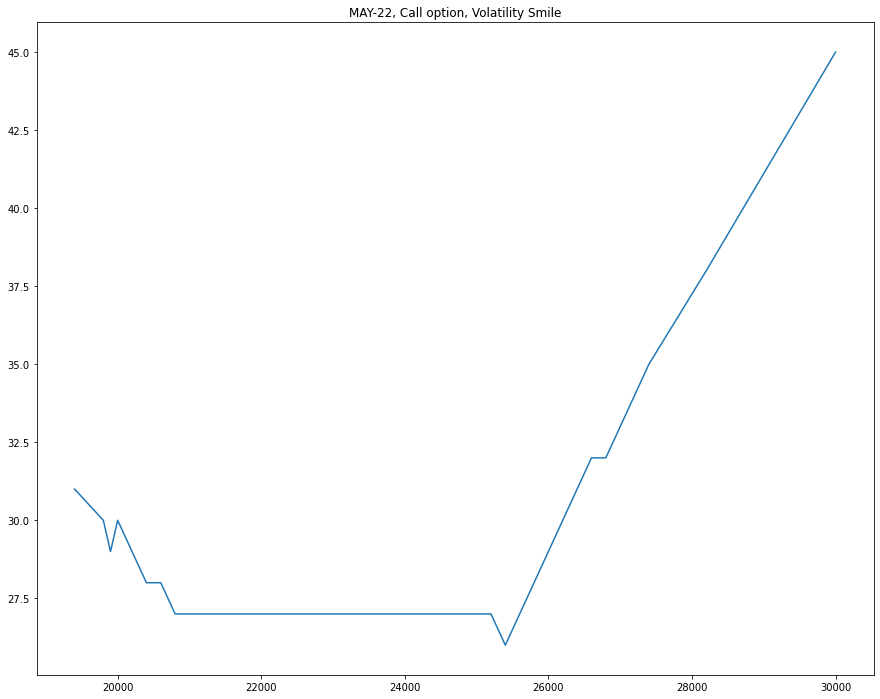

In [43]:
# filter only MAY-22 contract and Call options
df_t2_one = df_t2_non_zero[(df_t2_non_zero['month_contract'] == 'MAY-22') & (df_t2_non_zero['call/put'] == 'C')]
fig, ax1 = plt.subplots(1, figsize=(15, 12))
ax1.plot(df_t2_one['strike'], df_t2_one['IV%'])  # plot a chart
ax1.set_title('MAY-22, Call option, Volatility Smile')  # set the chart title

Text(0.5, 1.0, 'MAY-22, Put option, Volatility Smile')

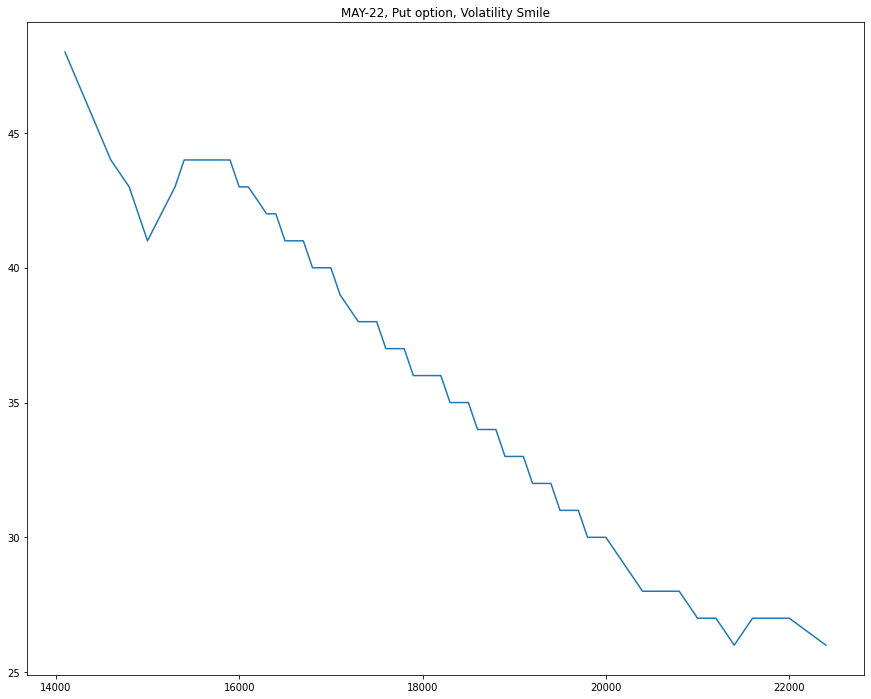

In [44]:
# filter only MAY-22 contract and Put options
df_t2_one = df_t2_non_zero[(df_t2_non_zero['month_contract'] == 'MAY-22') & (df_t2_non_zero['call/put'] == 'P')]
fig, ax1 = plt.subplots(1, figsize=(15, 12))
ax1.plot(df_t2_one['strike'], df_t2_one['IV%'])  # plot a chart
ax1.set_title('MAY-22, Put option, Volatility Smile')  # set the chart title

C:\Users\JEFFER~1\AppData\Local\Temp/ipykernel_15720/418906756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_one[f'IV%_{this_month}'] = df_t2_one.apply(lambda x: x['IV%'] if x['month_contract'] == this_month else np.nan, axis=1)


Text(0.5, 1.0, 'Call option, Volatility Smile for different expiration date')

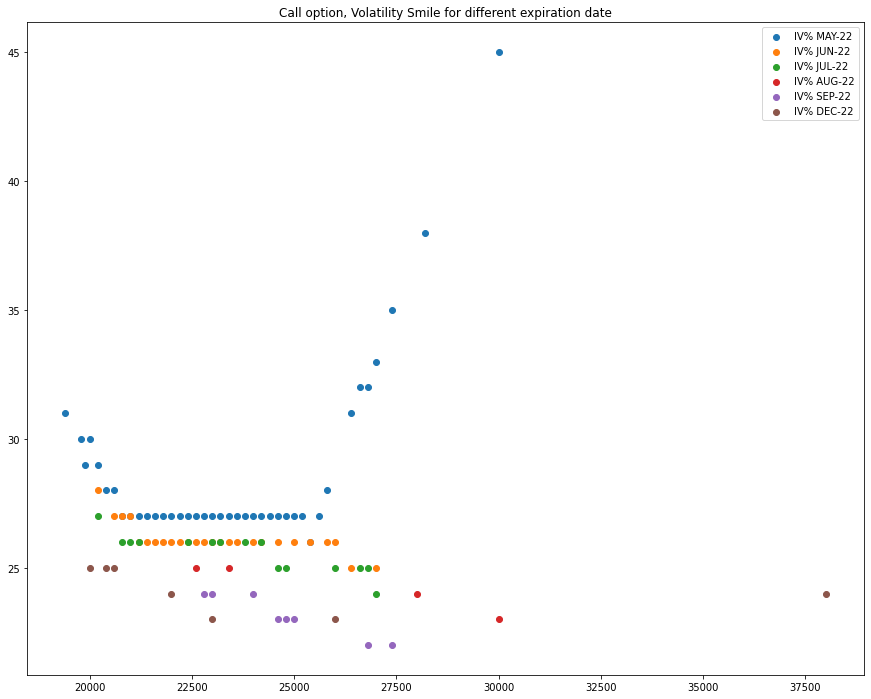

In [45]:
df_t2_non_zero = df_t2[df_t2['open'] != 0]  # filter options with trades only
df_t2_one = df_t2_non_zero[(df_t2_non_zero['call/put'] == 'C')]  # filter only call options
unique_month = df_t2_one['month_contract'].unique()  # calculate the unique months
for this_month in unique_month:  # for loop over unique months
    # add new columns for month contract, if this month, put IV% in new column, else put nan
    df_t2_one[f'IV%_{this_month}'] = df_t2_one.apply(lambda x: x['IV%'] if x['month_contract'] == this_month else np.nan, axis=1)

# plot multiple scatter plots
fig, ax1 = plt.subplots(1, figsize=(15, 12))
for this_month in unique_month:
    ax1.scatter(df_t2_one['strike'], df_t2_one[f'IV%_{this_month}'], label=f'IV% {this_month}')  # plot a chart
ax1.legend()
ax1.set_title('Call option, Volatility Smile for different expiration date')  # set the chart title

C:\Users\JEFFER~1\AppData\Local\Temp/ipykernel_15720/4002621231.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2_one[f'IV%_{this_month}'] = df_t2_one.apply(lambda x: x['IV%'] if x['month_contract'] == this_month else np.nan, axis=1)


Text(0.5, 1.0, 'Put option, Volatility Smile for different expiration date')

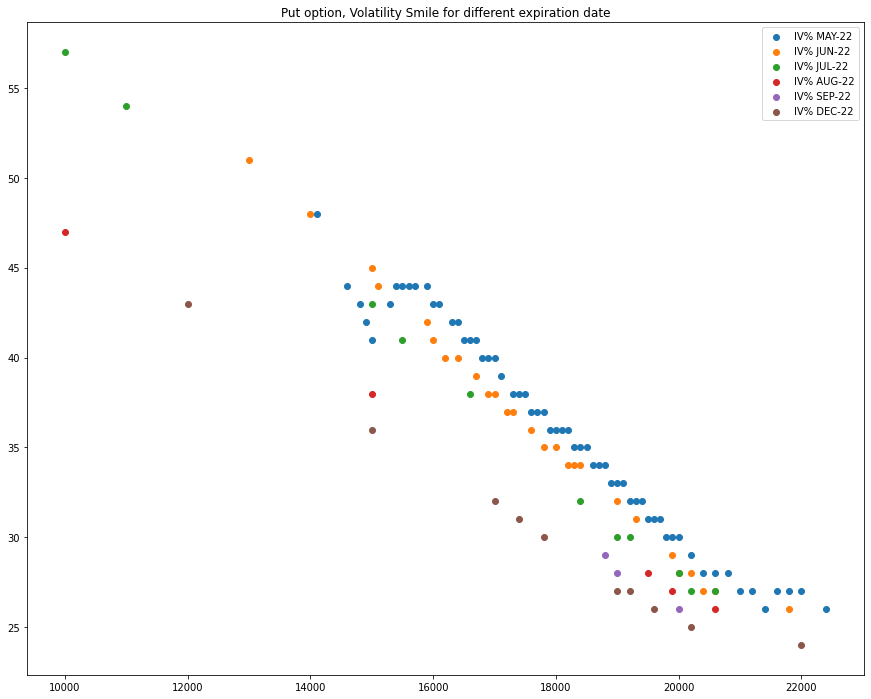

In [46]:
# see above comments, similar
df_t2_non_zero = df_t2[df_t2['open'] != 0]  # filter options with trades only
df_t2_one = df_t2_non_zero[(df_t2_non_zero['call/put'] == 'P')]
unique_month = df_t2_one['month_contract'].unique()
for this_month in unique_month:
    df_t2_one[f'IV%_{this_month}'] = df_t2_one.apply(lambda x: x['IV%'] if x['month_contract'] == this_month else np.nan, axis=1)

fig, ax1 = plt.subplots(1, figsize=(15, 12))
for this_month in unique_month:
    ax1.scatter(df_t2_one['strike'], df_t2_one[f'IV%_{this_month}'], label=f'IV% {this_month}')  # plot a chart
ax1.legend()
ax1.set_title('Put option, Volatility Smile for different expiration date')  # set the chart title

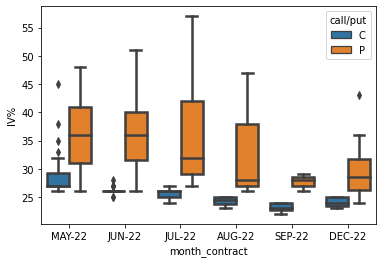

In [47]:
# boxplot of IV%
ax = sns.boxplot(x="month_contract", y="IV%", hue="call/put", data=df_t2_non_zero, linewidth=2.5)

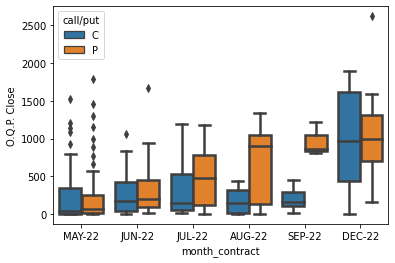

In [48]:
# boxplot of IV%
ax = sns.boxplot(x="month_contract", y="O.Q.P. Close", hue="call/put", data=df_t2_non_zero, linewidth=2.5)

In [54]:
# save final df to csv
df_t2_non_zero.to_csv('final_df.csv')

In [60]:
df_t2_non_zero


,month_contract,strike,call/put,open,high,low,O.Q.P. Close,O.Q.P. Change,IV%,volume
64,MAY-22,19400,C,1555.0,1555.0,1555.0,1523.0,-233.0,31.0,1.0
68,MAY-22,19800,C,1230.0,1240.0,1230.0,1211.0,-218.0,30.0,11.0
69,MAY-22,19900,C,1137.0,1137.0,1137.0,1137.0,-214.0,29.0,1.0
70,MAY-22,20000,C,1092.0,1092.0,1092.0,1081.0,-195.0,30.0,2.0
71,MAY-22,20200,C,1040.0,1040.0,918.0,927.0,-209.0,29.0,16.0
...,...,...,...,...,...,...,...,...,...,...
1301,DEC-22,19000,P,1118.0,1118.0,1118.0,1153.0,44.0,27.0,1.0
1303,DEC-22,19200,P,1206.0,1206.0,1206.0,1212.0,47.0,27.0,1.0
1307,DEC-22,19600,P,1298.0,1298.0,1298.0,1338.0,53.0,26.0,2.0
1312,DEC-22,20200,P,1565.0,1565.0,1565.0,1586.0,89.0,25.0,1.0
